# Setup

## Imports 

In [118]:
# Standard
import sys
# Third party
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import proplot as plot
# Local                                                                        
sys.path.append('/Users/46h/Research/code/accphys') 
from tools import (
    envelope_analysis as ea,
    coupling as BL,
    plotting as myplt,
    animation as myanim,
    utils)
from tools.utils import show, play, get_phase_adv, file_exists
from tools.plotting import save, set_labels

## Settings
Here are the available [stylesheets](https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html) and [color cycles](https://proplot.readthedocs.io/en/latest/cycles.html).

## Settings

In [119]:
# Plotting
plt_kws = dict(legend=False, xlabel='s / L')
plot.rc['figure.facecolor'] = 'white'
plot.rc['cycle'] = 'default'
plot.rc['style'] = None # https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html
plot.rc['savefig.dpi'] = 'figure' # proplot default is 1200, which makes inline animations appear huge
dpi = 500

# Animation
animate = True
skip = 10
fps = 3
anim_dpi = None

In [120]:
# Data file locations
files = {
    'position': '_output/data/position.npy', 
    'env_params': '_output/data/envelope/env_params.npy',
    'testbunch_coords': '_output/data/envelope/testbunch_coords.npy',
    'bunch_coords': '_output/data/bunch/bunch_coords.npy',
    'bunch_moments': '_output/data/bunch/bunch_moments.npy',
    'transfer_matrix': '_output/data/transfer_matrix.npy'
}
# Check if files exist
files_exist = {key: file_exists(file) for key, file in files.items()}

# Directories in which to save the figures
dirs = {
    'env': './_output/figures/envelope/',
    'bunch': './_output/figures/bunch/',
    'comparison': './_output/figures/comparison/'
}

In [121]:
width, height = 3.5, 2.5

def setup_figure(opt=1):
    """Convenience function to create subplots."""
    if opt == 1:
        nrows, ncols, figsize = 1, 1, (width, height)
    elif opt == 2:
        nrows, ncols, figsize = 3, 1, (width, 2*height)
    elif opt == 3:
        nrows, ncols, figsize = 3, 2, (1.6*width, 2*height)
    elif opt == 4:
        nrows, ncols, figsize = 1, 2, (7, 2.5)
    fig, axes = plot.subplots(nrows=nrows, ncols=ncols, figsize=figsize, spany=False, aligny=True)
    axes.format(xlabel='s / L')
    return fig, axes

# Envelope

In [122]:
mode = int(np.loadtxt('_output/data/mode.txt'))
env_params = np.load(files['env_params'])
position = np.load(files['position'])

env_stats = ea.Stats(mode)
env_stats.read_env(env_params)

# Add columns
env_stats.twiss2D['mux'] = get_phase_adv(env_stats.twiss2D['bx'], position, units='deg')
env_stats.twiss2D['muy'] = get_phase_adv(env_stats.twiss2D['by'], position, units='deg')

# Add position column
position_normed = position / position[-1]
for df in env_stats.dfs():
    df['s'] = position
    df['s/L'] = position_normed

## Twiss parameters 

### 2D Twiss

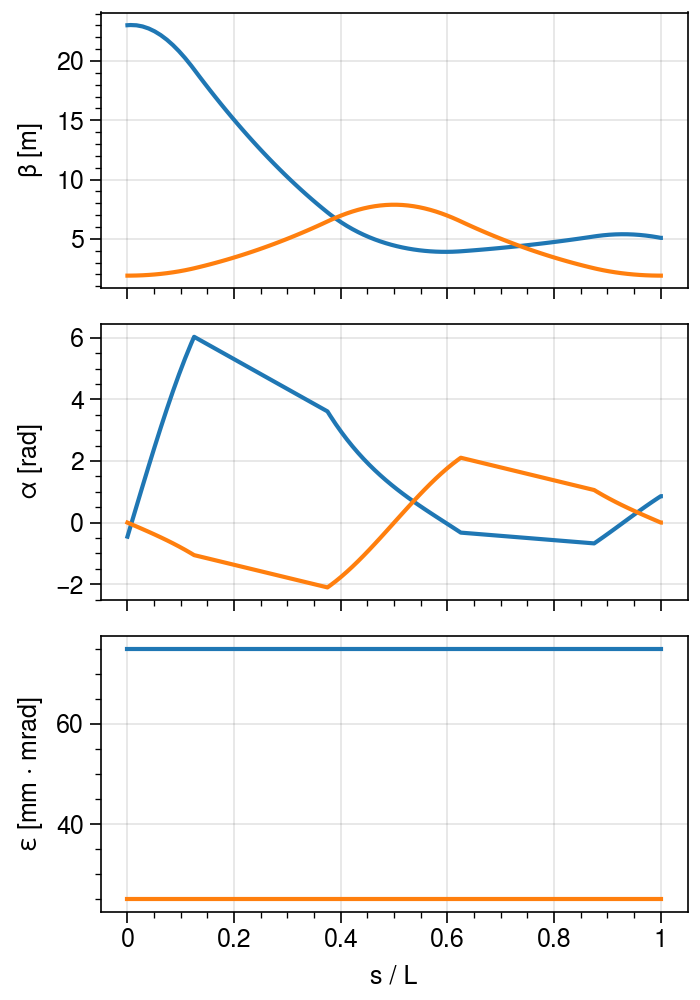

In [123]:
fig, axes = setup_figure(2)
env_stats.twiss2D[['s/L','bx','by']].plot('s/L', ax=axes[0], **plt_kws)
env_stats.twiss2D[['s/L','ax','ay']].plot('s/L', ax=axes[1], **plt_kws)
env_stats.twiss2D[['s/L','ex', 'ey']].plot('s/L', ax=axes[2], **plt_kws)
set_labels(axes, [r'$\beta$ [m]', r'$\alpha$ [rad]', r'$\varepsilon$ [mm $\cdot$ mrad]'], 'ylabel')
save('twiss2D', dirs['env'], dpi=dpi)

### 4D Twiss 

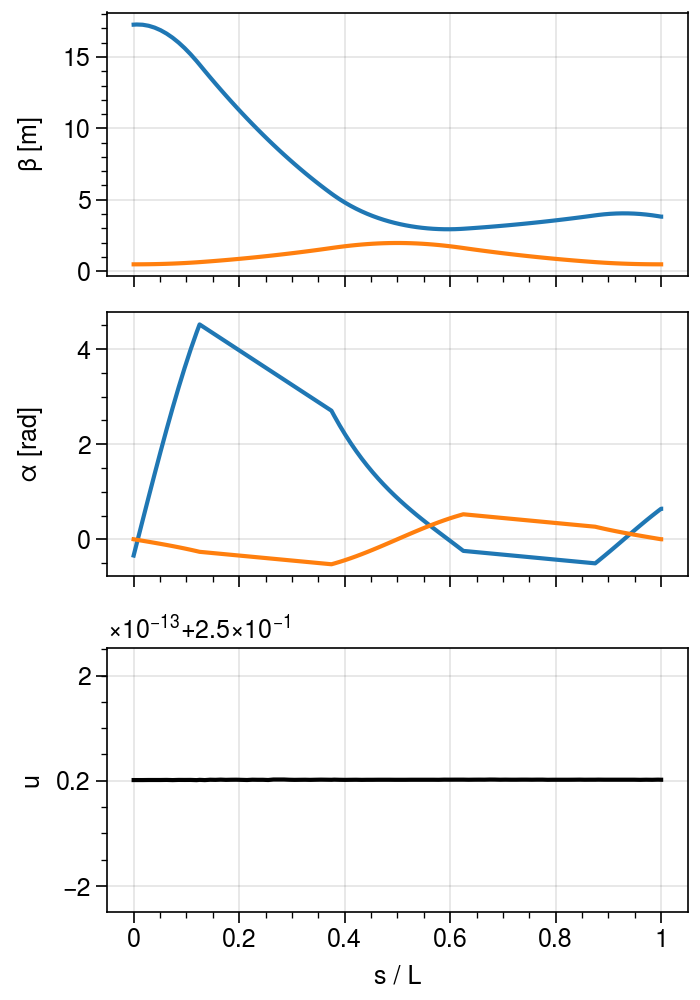

In [124]:
fig, axes = setup_figure(2)
env_stats.twiss4D[['s/L','bx','by']].plot('s/L', ax=axes[0], **plt_kws)
env_stats.twiss4D[['s/L','ax','ay']].plot('s/L', ax=axes[1], **plt_kws)
env_stats.twiss4D[['s/L','u']].plot('s/L', ax=axes[2], color='k', **plt_kws)
set_labels(axes, [r'$\beta$ [m]', r'$\alpha$ [rad]', 'u'], 'ylabel')
save('twiss4D', dirs['env'], dpi=dpi)

### Emittance 

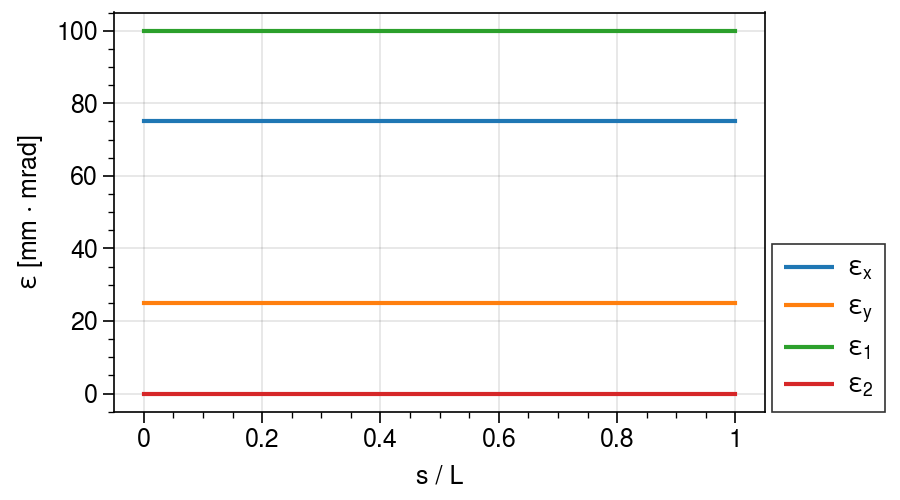

In [125]:
fig, ax = plot.subplots(figsize=(4.5, 2.5))
env_stats.twiss2D[['s/L','ex','ey']].plot('s/L', ax=ax, **plt_kws)
env_stats.twiss4D[['s/L','e1','e2']].plot('s/L', ax=ax, **plt_kws)
ax.format(ylabel=r'$\varepsilon$ [mm $\cdot$ mrad]')
ax.legend(labels=[r'$\varepsilon_x$', r'$\varepsilon_y$', r'$\varepsilon_1$', r'$\varepsilon_2$'], 
          ncols=1, loc=(1.01, 0))
save('emittance', dirs['env'], dpi=dpi)

### Phase advance 
The phase advance in the $x$ dimension is found by integrating the beam size and  emittance: 

$$\mu_x(s) = \int_{0}^{s}{\frac{\varepsilon_x(s')}{{\tilde{x}(s')}^2}} ds',$$

where $\tilde{x} = \sqrt{\langle{x^2}\rangle}$ and $s$ is the position in the lattice. The same expression holds with $x \longleftrightarrow y$.

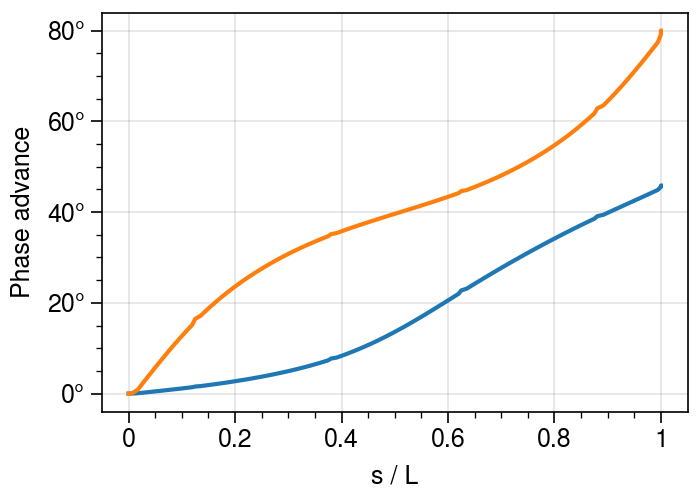

In [126]:
fig, ax = setup_figure(1)
env_stats.twiss2D[['s/L','mux','muy']].plot('s/L', ax=ax, **plt_kws)
ax.format(ylabel='Phase advance', yformatter='deg')
save('phase_adv', dirs['env'], dpi=dpi)

### Phase difference (nu)
The difference between every particle's $x$ and $y$ phases is related the the shape of the beam in real space as

$$
\cos\nu = \frac{\langle{xy}\rangle}{\sqrt{\langle{x^2}\rangle\langle{y^2}\rangle}}
$$

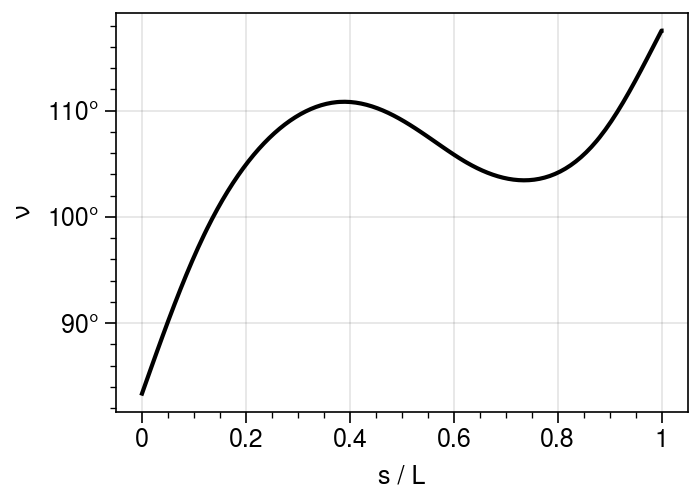

In [127]:
fig, ax = setup_figure(1)
env_stats.twiss4D[['s/L','nu']].plot('s/L', ax=ax, color='k', **plt_kws)
ax.format(ylabel=r'$\nu$', yformatter='deg')
save('twiss4D-nu', dirs['env'], dpi=dpi)

## Moments 

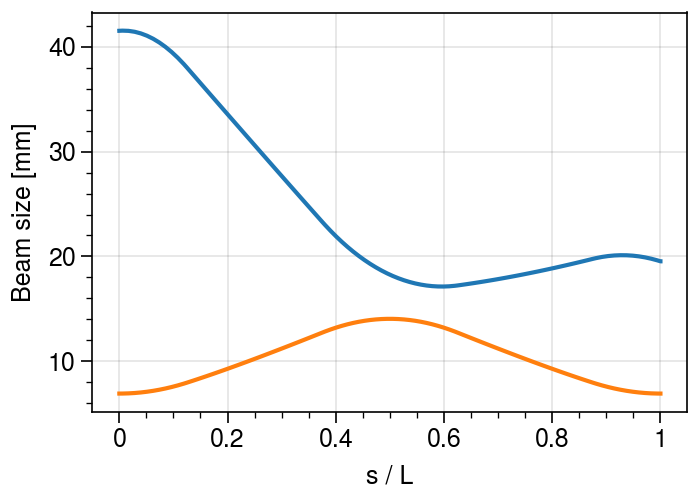

In [128]:
fig, ax = setup_figure(1)
env_stats.moments[['s/L','x_rms','y_rms']].plot('s/L', ax=ax, **plt_kws)
ax.format(ylabel='Beam size [mm]')
save('beamsize', dirs['env'], dpi=dpi)

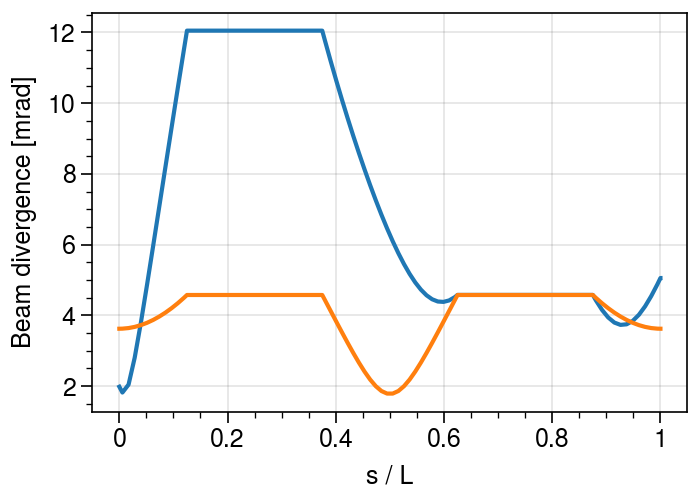

In [129]:
fig, ax = setup_figure(1)
env_stats.moments[['s/L','xp_rms','yp_rms']].plot('s/L', ax=ax, **plt_kws)
ax.format(ylabel='Beam divergence [mrad]')
save('beamdiv', dirs['env'], dpi=dpi)

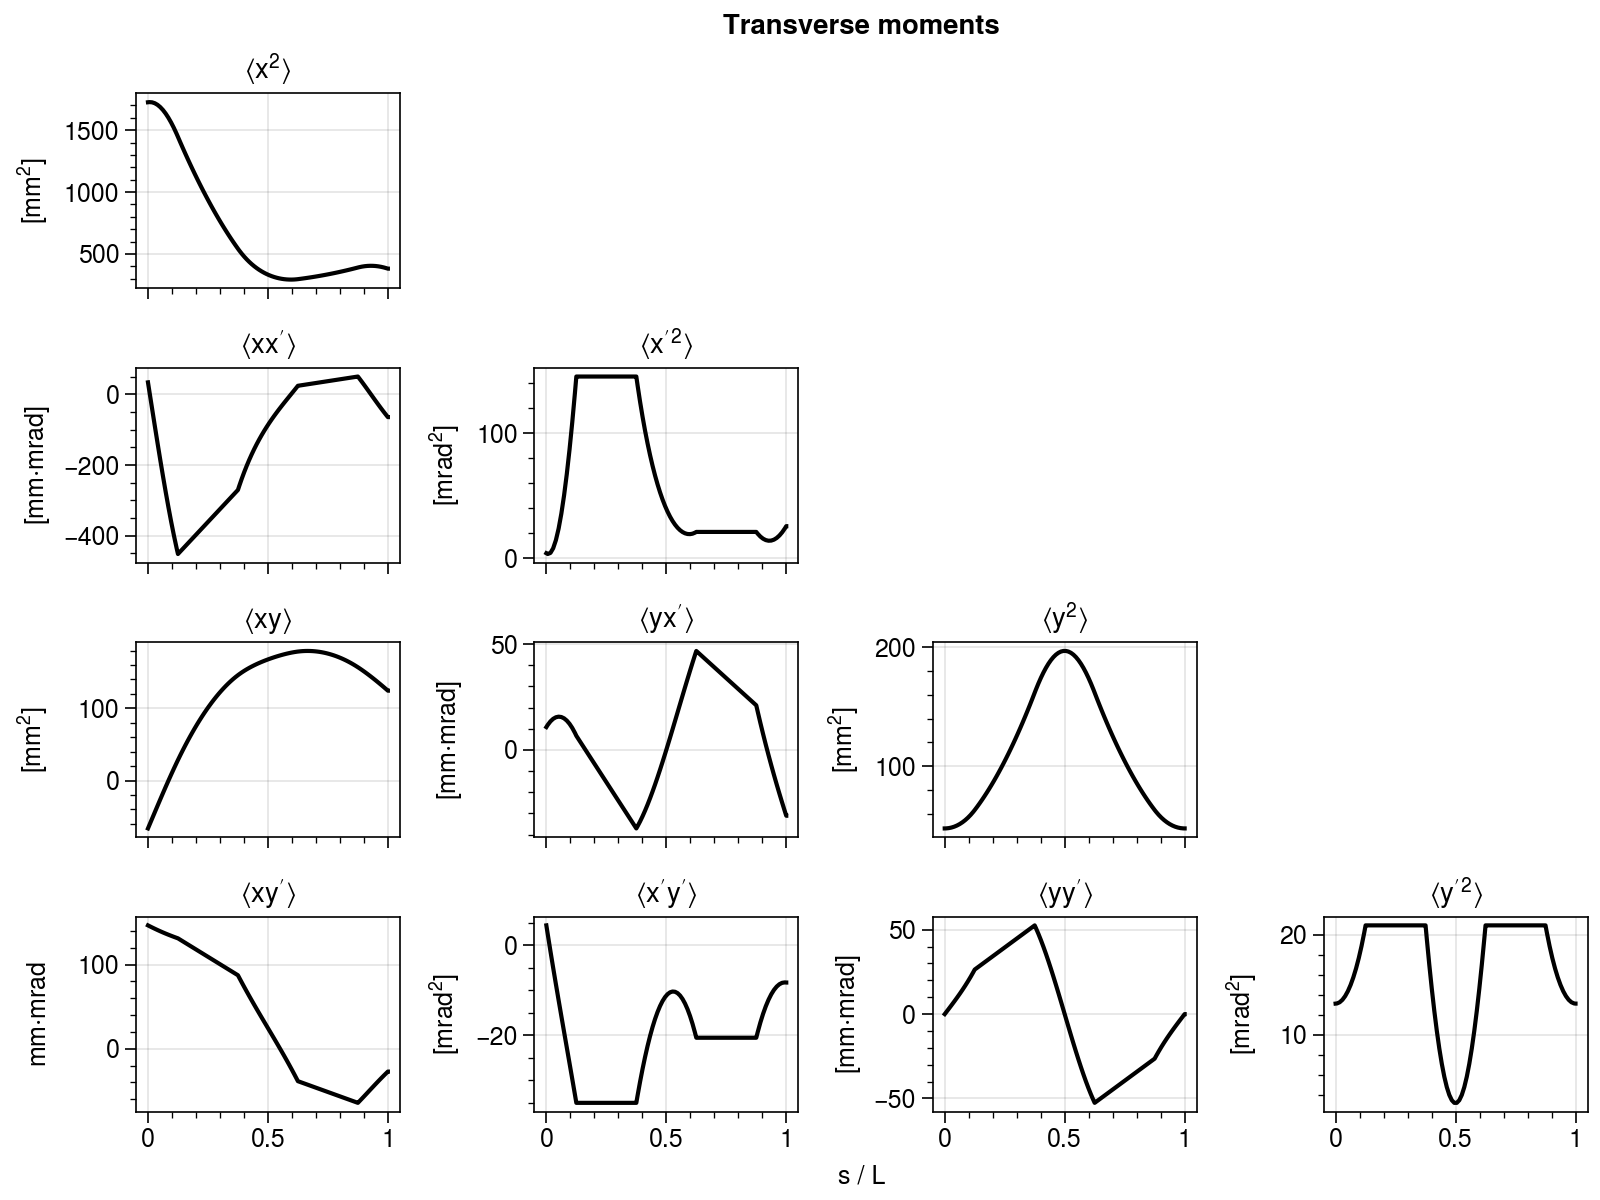

In [130]:
fig, axes = plot.subplots(nrows=4, ncols=4, sharey=False, figsize=(8, 6), 
                          spany=False, aligny=True)
myplt.make_lower_triangular(axes)
axes.format(xlabel='s / L', suptitle='Transverse moments', titleborder=True)

for i in range(4):
    for j in range(i + 1):
        ax = axes[i, j]
        col = utils.get_moments_key(i, j)
        env_stats.moments[['s/L',col]].plot('s/L', ax=ax, color='k', **plt_kws)
        ax.format(title=utils.get_moments_label(i, j))

set_labels(axes[0:, 0], [r'[mm$^2$]', r'[mm$\cdot$mrad]', r'[mm$^2$]', r'mm$\cdot$mrad'], 'ylabel')
set_labels(axes[1:, 1], [r'[mrad$^2$]', r'[mm$\cdot$mrad]', r'[mrad$^2$]'], 'ylabel')
set_labels(axes[2:, 2], [r'[mm$^2$]', r'[mm$\cdot$mrad]'], 'ylabel')
set_labels(axes[3:, 3], [r'[mrad$^2$]'], 'ylabel')
save('all_moments', dirs['env'], dpi=dpi)

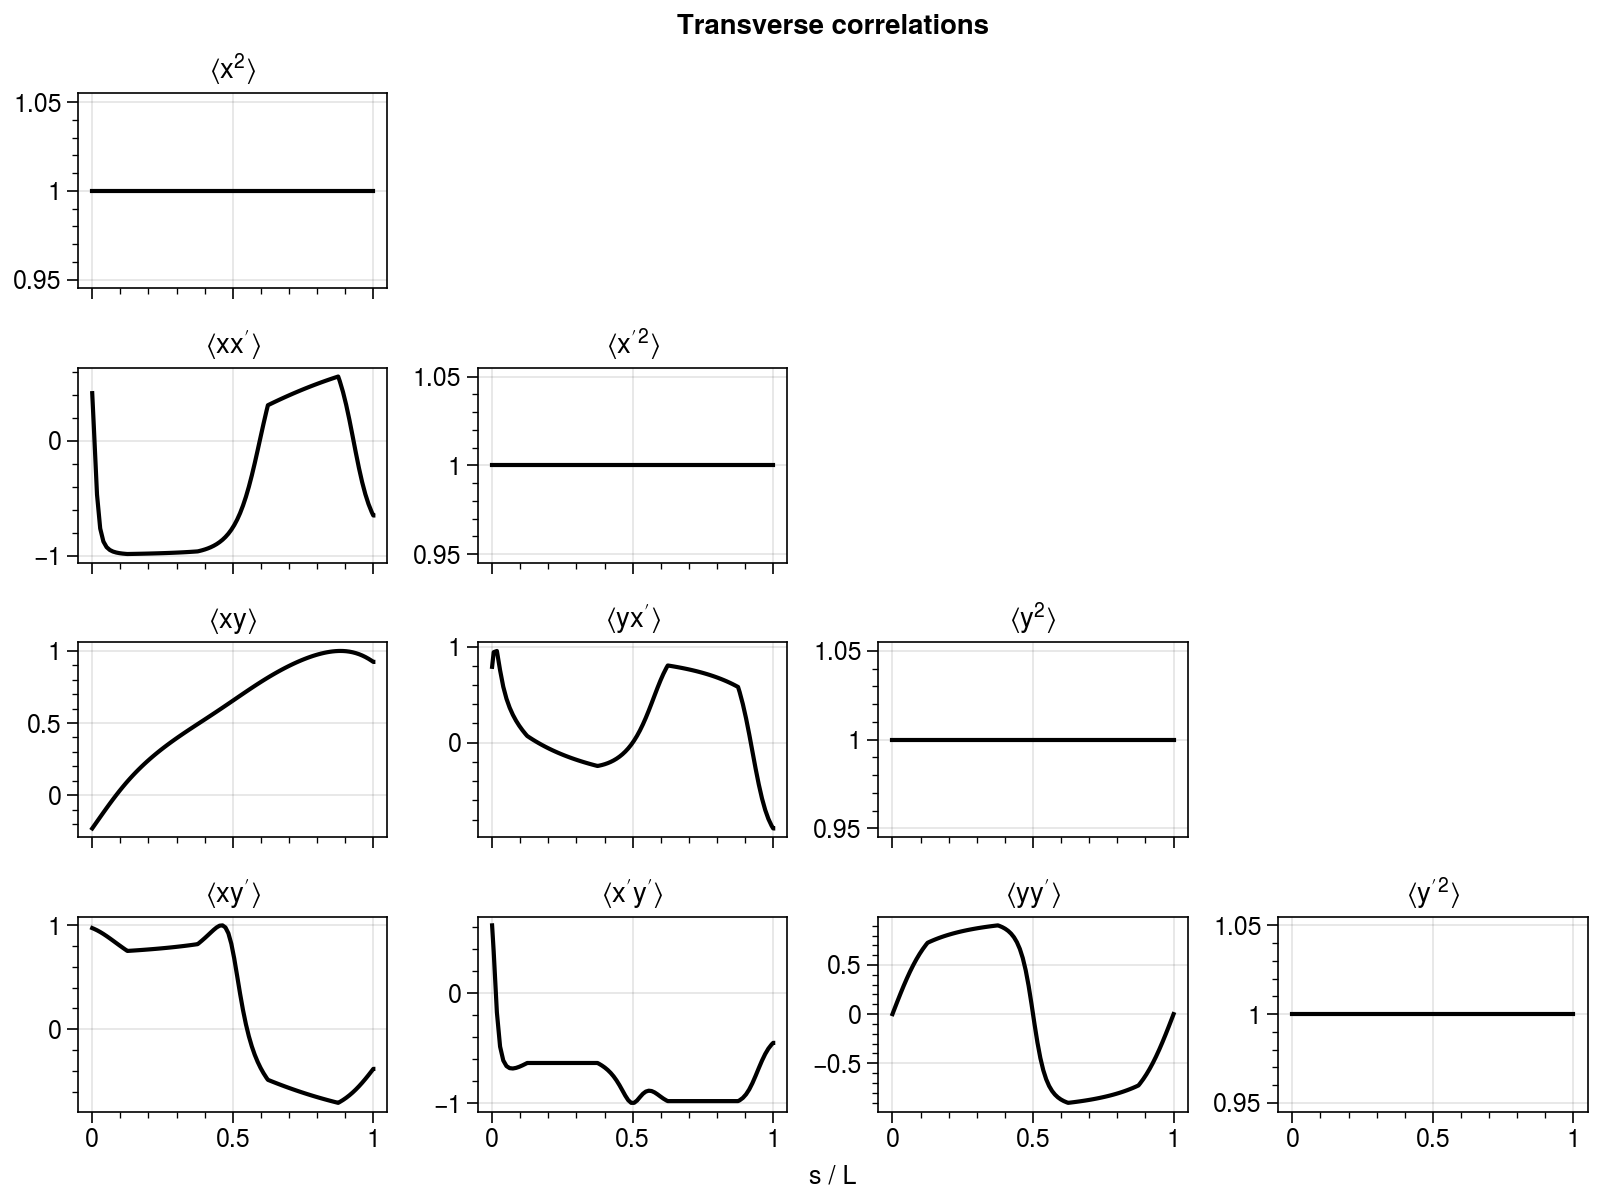

In [131]:
fig, axes = plot.subplots(nrows=4, ncols=4, sharey=False, figsize=(8, 6), 
                          spany=False, aligny=True)
myplt.make_lower_triangular(axes)
axes.format(suptitle='Transverse correlations', titleborder=True)

for i in range(4):
    for j in range(i + 1):
        ax = axes[i, j]
        col = utils.get_moments_key(i, j)
        env_stats.corr[['s/L',col]].plot('s/L', ax=ax, color='k', **plt_kws)
        ax.format(title=utils.get_moments_label(i, j))

save('all_correlations', dirs['env'], dpi=dpi)

## Real space orientation

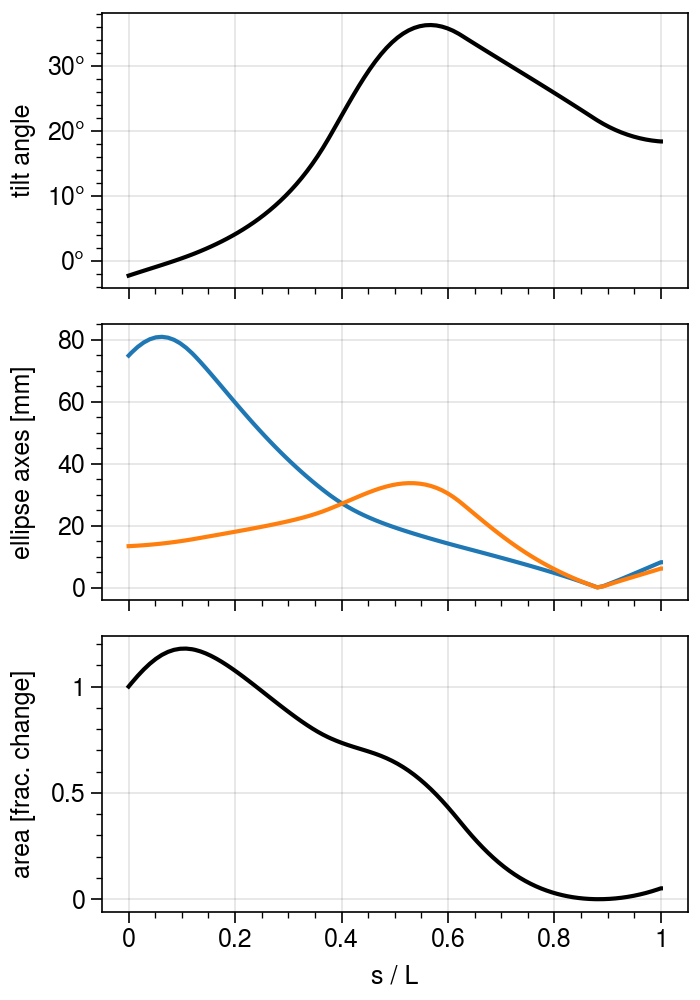

In [132]:
fig, axes = setup_figure(2)
env_stats.realspace[['s/L','angle']].plot('s/L', color='k', ax=axes[0], **plt_kws)
env_stats.realspace[['s/L','cx','cy']].plot('s/L', ax=axes[1], **plt_kws)
env_stats.realspace[['s/L','area_rel']].plot('s/L', ax=axes[2], color='k', **plt_kws)
set_labels(axes, ['tilt angle', 'ellipse axes [mm]', 'area [frac. change]'], 'ylabel')
axes[0].format(yformatter='deg')
save('realspace_ellipse', dirs['env'], dpi=dpi)

## Miscellaneous

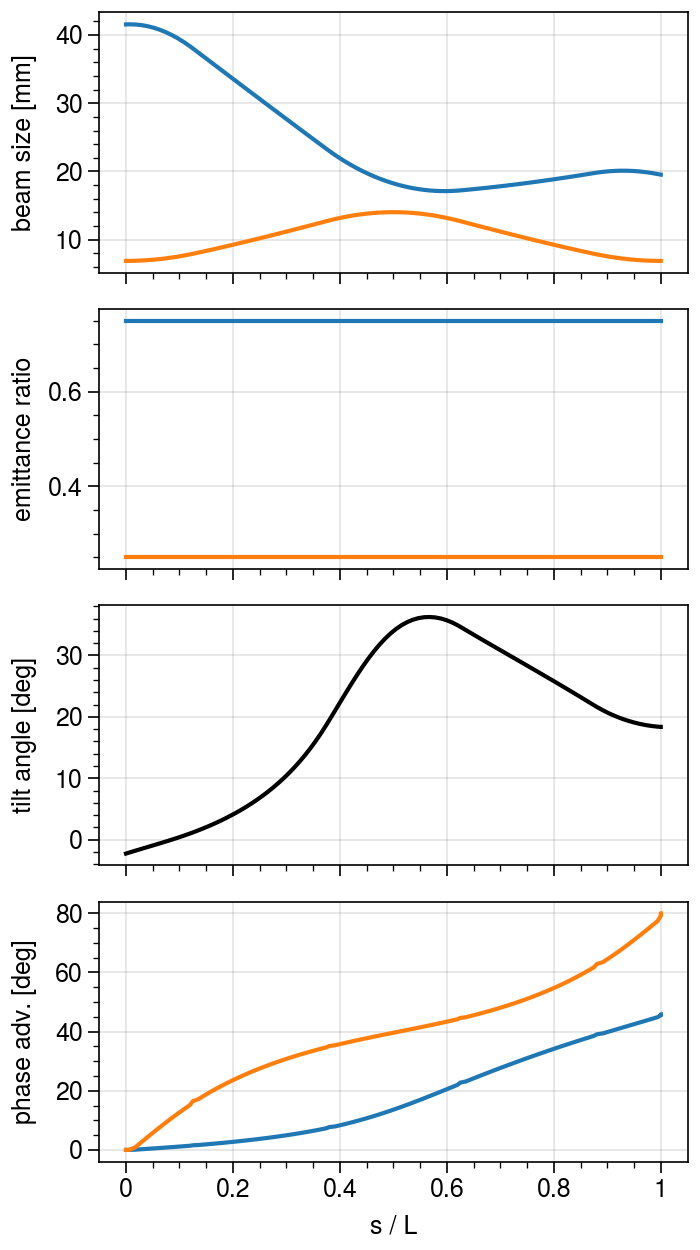

In [133]:
fig, axes = plot.subplots(nrows=4, ncols=1, figsize=(width, 2.5*height), spany=False, aligny=True)
env_stats.moments[['s/L','x_rms','y_rms']].plot('s/L', ax=axes[0], **plt_kws)
env_stats.twiss2D[['s/L','ex_frac','ey_frac']].plot('s/L', ax=axes[1], **plt_kws)
env_stats.realspace[['s/L','angle']].plot('s/L', ax=axes[2], color='k', **plt_kws)
env_stats.twiss2D[['s/L','mux','muy']].plot('s/L', ax=axes[3], **plt_kws)
set_labels(axes, ['beam size [mm]', 'emittance ratio', 'tilt angle [deg]', 'phase adv. [deg]'], 'ylabel')    
save('vert', dirs['env'], dpi=dpi)

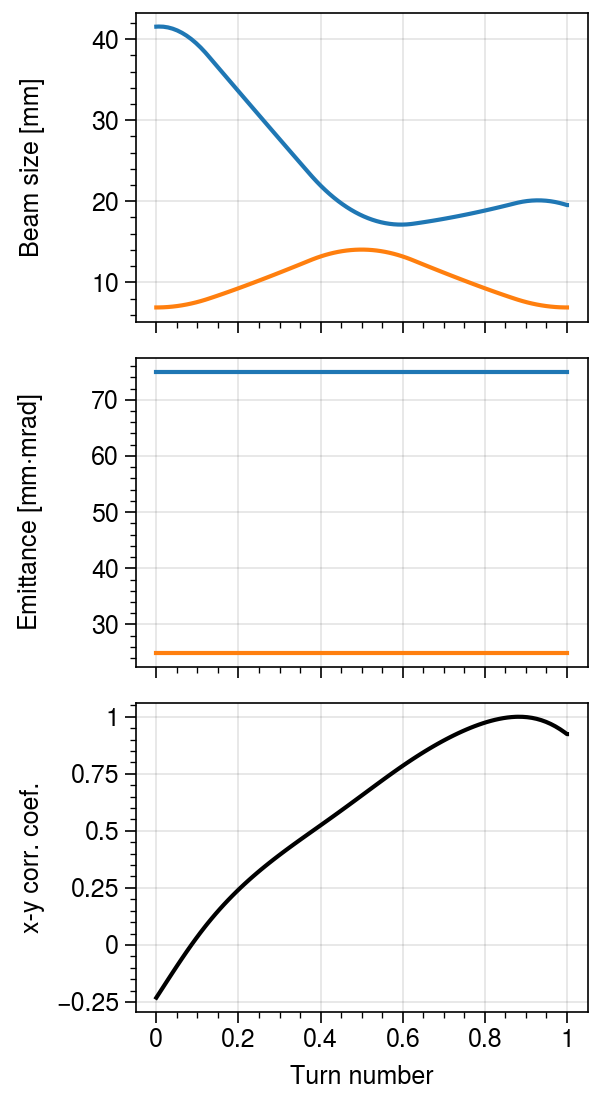

In [134]:
fig, axes = plot.subplots(nrows=3, figsize=(3, 5.5), spany=False, aligny=True)
env_stats.moments[['s/L','x_rms','y_rms']].plot('s/L', ax=axes[0], **plt_kws)
env_stats.twiss2D[['s/L','ex','ey']].plot('s/L', ax=axes[1], **plt_kws)
env_stats.corr[['s/L','xy']].plot('s/L', ax=axes[2], color='k', **plt_kws)
set_labels(axes, ['Beam size [mm]', r'Emittance [mm$\cdot$mrad]', 'x-y corr. coef.'], 'ylabel')
axes.format(xlabel='Turn number')
save('misc', dirs['env'], dpi=dpi)

## Phase space projections 

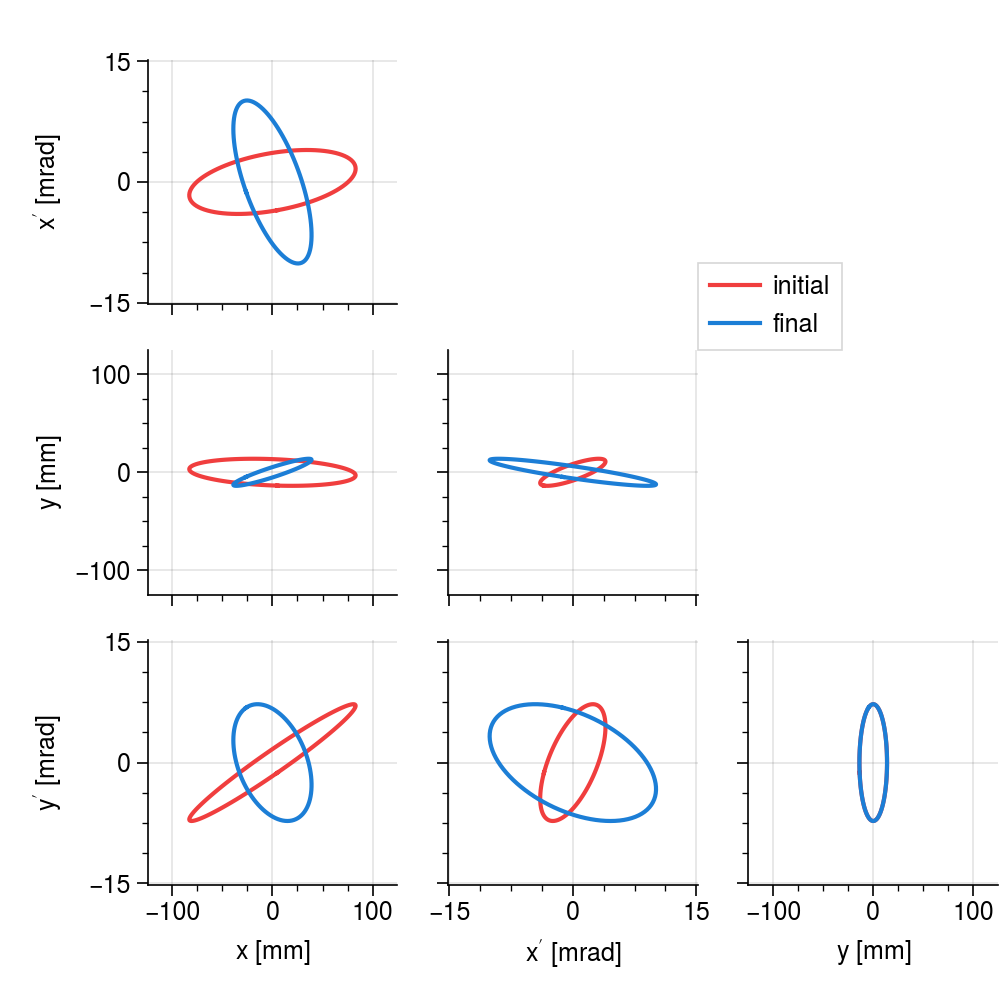

In [135]:
axes = myplt.corner_env(
    env_params[[0, -1]], cmap=plot.Colormap(('red7', 'blue7')),
    legend_kws=dict(labels=['initial','final'], loc=(1, 1))
)
save('init_final', dirs['env'], dpi=dpi)

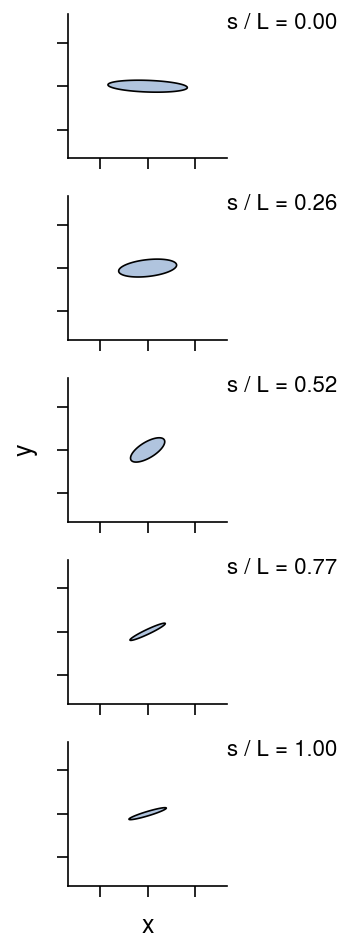

In [136]:
nframes = len(position)
idx = [0, nframes//4, nframes//2, 3*nframes//4, nframes - 1]
ellipse_coords_list = ea.get_ellipse_coords(env_params[idx])
s_list = position_normed[idx]
umax, upmax = myplt.get_u_up_max_global(ellipse_coords_list)
umax *= 2

fig, axes = plot.subplots(nrows=len(idx), figsize=(1.75, 4.75))
axes.format(
    grid=False, xlim=(-umax, umax), ylim=(-umax, umax), yticklabels=[], xticklabels=[],
    xtickminor=False, ytickminor=False, ylabel=r'$y$', xlabel=r'$x$'
)
for ax, X, s in zip(axes, ellipse_coords_list, s_list):
    ax.fill(X[:, 0], X[:, 2], ec='k', fc='lightsteelblue', zorder=2)
    ax.annotate('s / L = {:.2f}'.format(s), xy=(1, 0.9), 
            xycoords='axes fraction', fontsize=8)
    for s in ['top', 'right']:
        ax.spines[s].set_visible(False)
    
save('snapshots', dirs['env'], dpi=dpi)

In [137]:
if animate:
    anim = myanim.corner_env(env_params, skip=skip, fps=fps, figsize=5,
                             text_vals=position_normed, text_fmt='s / L = {:.2f}')
    play(anim)

## Transfer matrix 

In [165]:
if files_exist['transfer_matrix']:
    M = np.load(files['transfer_matrix'])
    M_eigvals, M_eigvecs = np.linalg.eig(M)
    M_eigtunes = np.degrees(np.arccos(M_eigvals.real))

    show(M, 'M')
    print()
    show(M_eigvals[[0, 2]], 'eigenvalues')
    print()
    show(M_eigtunes[[0, 2]], 'eigentunes [deg]')

M =
⎡0.174   7.763   0.0     0.0 ⎤
⎢                            ⎥
⎢-0.125  0.174   0.0     0.0 ⎥
⎢                            ⎥
⎢ 0.0     0.0   0.174   1.875⎥
⎢                            ⎥
⎣ 0.0     0.0   -0.517  0.174⎦

eigenvalues =
⎡0.174 + 0.985⋅ⅈ⎤
⎢               ⎥
⎣0.174 + 0.985⋅ⅈ⎦

eigentunes [deg] =
⎡80.0⎤
⎢    ⎥
⎣80.0⎦


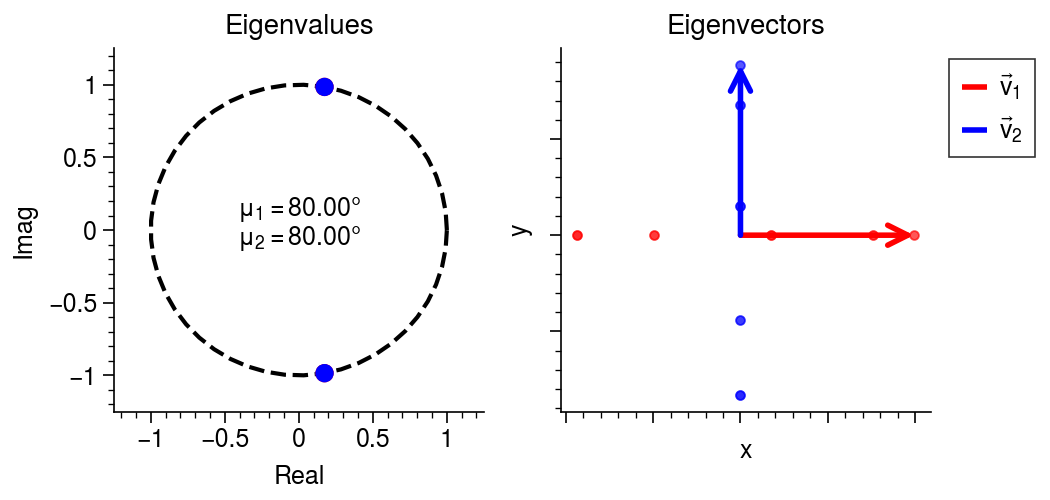

In [139]:
if files_exist['transfer_matrix']:
    
    fig, axes = plot.subplots(ncols=2, figsize=(5.25, 2.5), share=False, span=False)
    axes.format(grid=False)
    myplt.despine(axes)
    ax1, ax2 = axes

    # Plot eigenvalues in complex plane
    psi = np.linspace(0, 2*np.pi, 50)
    x_circ, y_circ = np.cos(psi), np.sin(psi)
    ax1.plot(x_circ, y_circ, 'k--', zorder=0)
    ax1.scatter(M_eigvals.real, M_eigvals.imag, c=['r','r','b','b'])
    scale = 1.25
    ax1.format(
        xticks=[-1, -0.5, 0, 0.5, 1], yticks=[-1, -0.5, 0, 0.5, 1], 
        ylim=(-scale, scale), xlim=(-scale, scale),
        xlabel='Real', ylabel='Imag', title='Eigenvalues')
    ax1.annotate(r'$\mu_1 = {:.2f}\degree$'.format(M_eigtunes[0]), xy=(0, +0.1), horizontalalignment='center')
    ax1.annotate(r'$\mu_2 = {:.2f}\degree$'.format(M_eigtunes[2]), xy=(0, -0.1), horizontalalignment='center')

    # Plot turn-by-turn trajectory of eigenvectors
    myplt.eigvec_trajectory(ax2, M, 'x', 'y', s=10)
    ax2.format(xticklabels=[], yticklabels=[], 
               ylabel='y', xlabel='x', title='Eigenvectors')

    # Add legend
    custom_lines = [matplotlib.lines.Line2D([0], [0], color='r', lw=2),
                    matplotlib.lines.Line2D([0], [0], color='b', lw=2)]
    ax2.legend(custom_lines, [r'$\vec{v}_1$', r'$\vec{v}_2$'],
               loc=(1.05, 0.7), handlelength=1, ncols=1);

    save('eigvecs_realspace', dirs['env'], dpi=dpi)

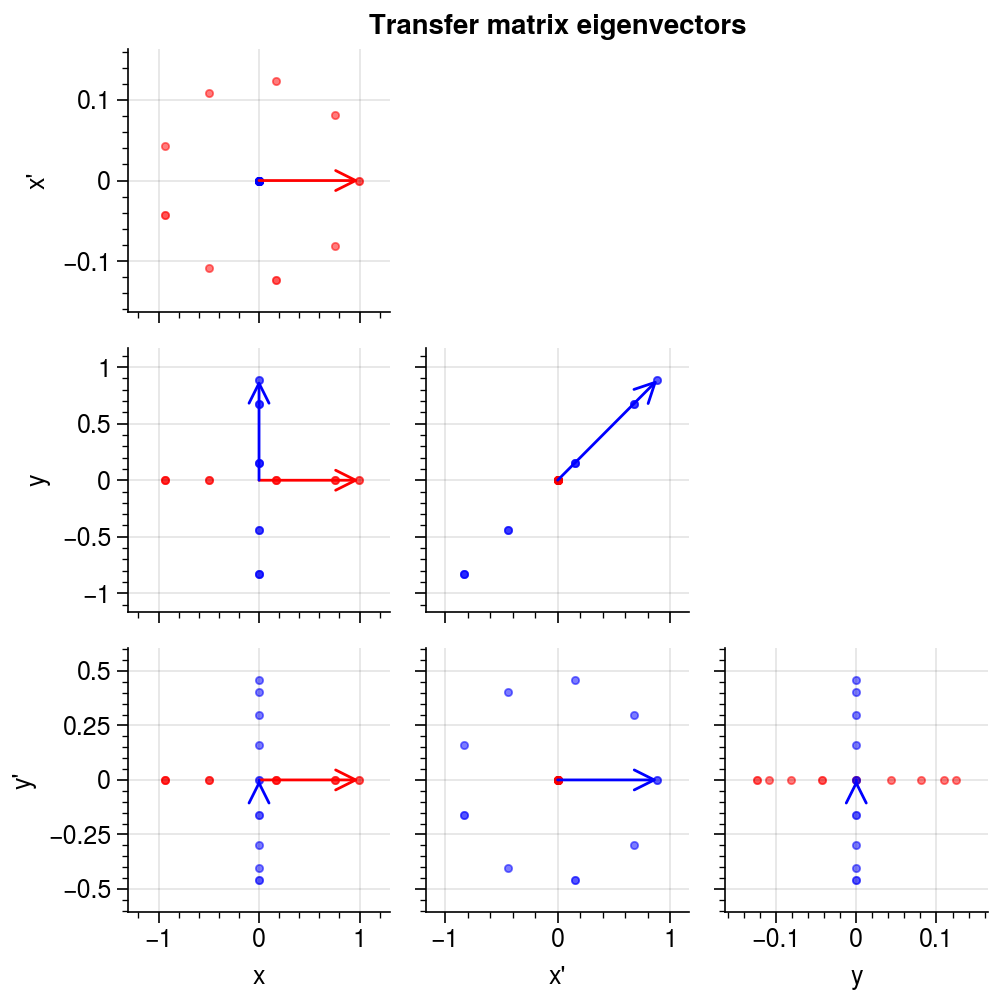

In [140]:
if files_exist['transfer_matrix']:
    
    # Set up figure
    fig, axes = plot.subplots(nrows=3, ncols=3, figsize=(5, 5), span=False)
    axes.format(grid=True, suptitle='Transfer matrix eigenvectors')
    myplt.make_lower_triangular(axes)
    myplt.despine(axes)

    labels = ["x", "x'", "y", "y'"]
    xlabels, ylabels = labels[:-1], labels[1:]
    set_labels(axes[-1, :], xlabels, 'xlabel')
    set_labels(axes[:, 0], ylabels, 'ylabel')

    # Plot eigenvectors and their trajectories
    for i in range(3):
        for j in range(3):
            if i >= j:
                ax = axes[i, j]
                yvar = ['xp', 'y', 'yp'][i]
                xvar = ['x', 'y', 'xp'][j]
                myplt.eigvec_trajectory(ax, M, xvar, yvar, s=7, lw=1)

    # Zoom out a bit
    for i in range(3):
        ymin, ymax = axes[i, 0].get_ylim()
        xmin, xmax = axes[-1, i].get_xlim()
        scale = 1.2
        axes[i, :].format(ylim=(-scale*ymax, scale*ymax))
        axes[:, i].format(xlim=(-scale*xmax, scale*xmax))

    save('eigvecs', dirs['env'], dpi=dpi)

## Test bunch

In [141]:
if files_exist['testbunch_coords']:
    
    test_coords = np.load(files['testbunch_coords'])
    nframes, ntestparts, ndims = test_coords.shape
    print('nparts, nframes = {}, {}'.format(ntestparts, nframes))
    
    test_cdfs = []
    for X in test_coords:
        cdf = pd.DataFrame(X, columns=['x','xp','y','yp'])
        cdf[['s','s/L']] = env_stats.env_params[['s','s/L']]
        test_cdfs.append(cdf)

nparts, nframes = 100, 102


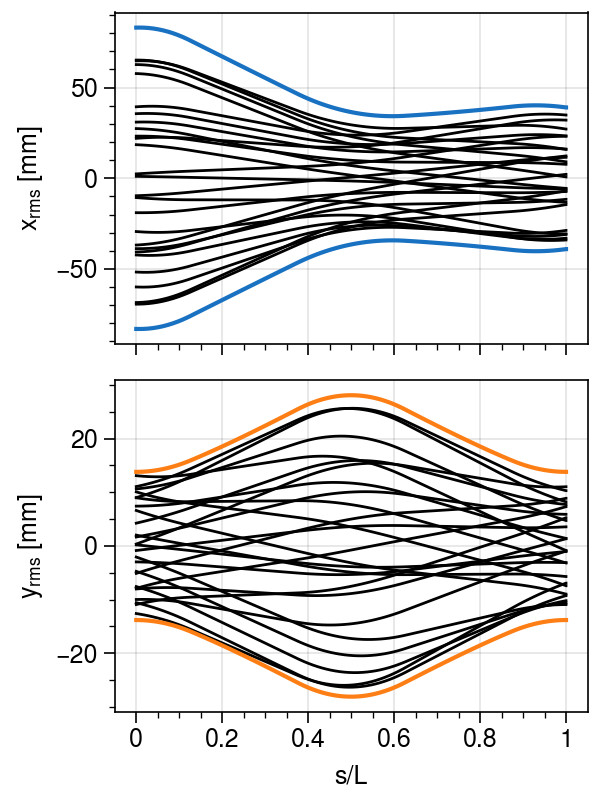

In [142]:
if files_exist['testbunch_coords']:
    
    fig, axes = plot.subplots(nrows=2, sharey=False, figsize=(3, 4))
    set_labels(axes, [r'$x_{rms}$ [mm]', r'$y_{rms}$ [mm]'], 'ylabel')
    
    for part_idx in range(0, ntestparts, 4):
        X = pd.DataFrame(test_coords[:, part_idx, :], columns=['x','xp','y','yp'])
        X['s/L'] = position_normed
        X[['s/L','x']].plot('s/L', color='k', lw=1, legend=False, ax=axes[0])
        X[['s/L','y']].plot('s/L', color='k', lw=1, legend=False, ax=axes[1])

    x_env = 2 * env_stats.moments['x_rms']
    y_env = 2 * env_stats.moments['y_rms']
    for ax, env, c in zip(axes, (x_env, y_env), ('blue8','orange6')):
        ax.plot(position_normed, +env, c=c)
        ax.plot(position_normed, -env, c=c)
        
    save('testbunch_beamsize', dirs['env'], dpi=dpi)

# Distribution

In [143]:
if files_exist['bunch_coords']:
    coords = np.load(files['bunch_coords'])    
    cdfs = []
    for X in coords:
        cdf = pd.DataFrame(X, columns=['x','xp','y','yp'])
        cdfs.append(cdf)
    print('Bunch coordinates:')
    print('nframes, nparts = {}, {}'.format(*coords.shape))
        
if files_exist['bunch_moments']:
    moments = np.load(files['bunch_moments'])
    bunch_stats = ea.Stats(mode)
    bunch_stats.read_moments(moments)
    bunch_stats.twiss2D['mux'] = get_phase_adv(bunch_stats.twiss2D['bx'], position, 'deg')
    bunch_stats.twiss2D['muy'] = get_phase_adv(bunch_stats.twiss2D['by'], position, 'deg')
    for df in bunch_stats.dfs():
        df['s'] = position
        df['s/L'] = position_normed

## Twiss parameters 

### 2D Twiss

In [144]:
if files_exist['bunch_moments']:
    fig, axes = setup_figure(2)
    bunch_stats.twiss2D[['s/L','bx','by']].plot('s/L', ax=axes[0], **plt_kws)
    bunch_stats.twiss2D[['s/L','ax','ay']].plot('s/L', ax=axes[1], **plt_kws)
    bunch_stats.twiss2D[['s/L','ex', 'ey']].plot('s/L', ax=axes[2], **plt_kws)
    set_labels(axes, [r'$\beta$ [m]', r'$\alpha$ [rad]', r'$\varepsilon$ [mm $\cdot$ mrad]'], 'ylabel')
    save('twiss2D', dirs['bunch'], dpi=dpi)

### Emittance 

In [145]:
if files_exist['bunch_moments']:
    fig, ax = plot.subplots(figsize=(4.5, 2.5))
    bunch_stats.twiss2D[['s/L','ex','ey']].plot('s/L', ax=ax, **plt_kws)
    bunch_stats.twiss4D[['s/L','e1','e2']].plot('s/L', ax=ax, **plt_kws)
    ax.format(ylabel=r'$\varepsilon$ [mm $\cdot$ mrad]')
    ax.legend(labels=[r'$\varepsilon_x$', r'$\varepsilon_y$', r'$\varepsilon_1$', r'$\varepsilon_2$'], 
              ncols=1, loc=(1.01, 0))
    save('emittance', dirs['bunch'], dpi=dpi)

### Phase advance 

In [146]:
if files_exist['bunch_moments']:
    fig, ax = setup_figure(1)
    bunch_stats.twiss2D[['s/L','mux','muy']].plot('s/L', ax=ax, **plt_kws)
    ax.format(ylabel='Phase advance', yformatter='deg')
    save('phase_adv', dirs['bunch'], dpi=dpi)

## Moments 

In [147]:
if files_exist['bunch_moments']:
    fig, ax = setup_figure(1)
    bunch_stats.moments[['s/L','x_rms','y_rms']].plot('s/L', ax=ax, **plt_kws)
    ax.format(ylabel='Beam size [mm]')
    save('beamsize', dirs['bunch'], dpi=dpi)

In [148]:
if files_exist['bunch_moments']:
    fig, ax = setup_figure(1)
    bunch_stats.moments[['s/L','xp_rms','yp_rms']].plot('s/L', ax=ax, **plt_kws)
    ax.format(ylabel='Beam divergence [mrad]')
    save('beamdiv', dirs['bunch'], dpi=dpi)

In [149]:
if files_exist['bunch_moments']:
    fig, axes = plot.subplots(nrows=4, ncols=4, sharey=False, figsize=(8, 6), 
                              spany=False, aligny=True)
    myplt.make_lower_triangular(axes)
    axes.format(suptitle='Transverse moments', titleborder=True)

    for i in range(4):
        for j in range(i + 1):
            ax = axes[i, j]
            col = utils.get_moments_key(i, j)
            bunch_stats.moments[['s/L',col]].plot('s/L', ax=ax, color='k', **plt_kws)
            ax.format(title=utils.get_moments_label(i, j))

    set_labels(axes[0:, 0], [r'[mm$^2$]', r'[mm$\cdot$mrad]', r'[mm$^2$]', r'mm$\cdot$mrad'], 'ylabel')
    set_labels(axes[1:, 1], [r'[mrad$^2$]', r'[mm$\cdot$mrad]', r'[mrad$^2$]'], 'ylabel')
    set_labels(axes[2:, 2], [r'[mm$^2$]', r'[mm$\cdot$mrad]'], 'ylabel')
    set_labels(axes[3:, 3], [r'[mrad$^2$]'], 'ylabel')
    save('all_moments', dirs['bunch'], dpi=dpi)

In [150]:
if files_exist['bunch_moments']:
    fig, axes = plot.subplots(nrows=4, ncols=4, sharey=False, figsize=(8, 6), 
                              spany=False, aligny=True)
    myplt.make_lower_triangular(axes)
    axes.format(suptitle='Transverse correlations', titleborder=True)

    for i in range(4):
        for j in range(i + 1):
            ax = axes[i, j]
            col = utils.get_moments_key(i, j)
            bunch_stats.corr[['s/L', col]].plot('s/L', ax=ax, color='k', **plt_kws)
            ax.format(title=utils.get_moments_label(i, j))

    save('all_correlations', dirs['bunch'], dpi=dpi)

## Real space orientation

In [151]:
if files_exist['bunch_moments']:
    fig, axes = setup_figure(2)
    bunch_stats.realspace[['s/L','angle']].plot('s/L', ax=axes[0], **plt_kws)
    bunch_stats.realspace[['s/L','cx','cy']].plot('s/L', ax=axes[1], **plt_kws)
    bunch_stats.realspace[['s/L','area_rel']].plot('s/L', ax=axes[2], color='k', **plt_kws)
    set_labels(axes, ['tilt angle', 'ellipse axes [mm]', 'area [frac. change]'], 'ylabel')
    axes[0].format(yformatter='deg')
    save('beam_dims', dirs['bunch'], dpi=dpi)

In [152]:
if files_exist['bunch_moments']:
    fig, axes = plot.subplots(nrows=4, ncols=1, figsize=(0.8*width, 2.5*height), 
                              spany=False, aligny=True)
    bunch_stats.moments[['s/L','x_rms','y_rms']].plot('s/L', ax=axes[0], **plt_kws)
    bunch_stats.twiss2D[['s/L','ex_frac','ey_frac']].plot('s/L', ax=axes[1], **plt_kws)
    bunch_stats.realspace[['s/L','angle']].plot('s/L', ax=axes[2], color='k', **plt_kws)
    bunch_stats.twiss2D[['s/L','mux','muy']].plot('s/L', ax=axes[3], **plt_kws)
    ylabels = ['beam size [mm]', 'emittance ratio', 'tilt angle [deg]', 'phase adv. [deg]']
    set_labels(axes, ylabels, 'ylabel')    
    save('vert', dirs['bunch'], dpi=dpi)

## Phase space projections 

In [153]:
if files_exist['bunch_coords']:
    for i, name in zip((1, -1), ('Initial', 'Final')):
        axes = myplt.corner(coords[i], text=name, figsize=5, pad=0.25)
        save(name, dirs['bunch'], dpi=dpi)

In [154]:
if animate and files_exist['bunch_coords']:
    anim = myanim.corner(coords, skip=skip, figsize=6, 
                         diag_kind='hist', fps=fps, pad=0.25,
                         text_fmt='s / L = {:.2f}', text_vals=position_normed)
    play(anim)

We should double check the histogram y limits on the above animation.

# Comparison 

In [155]:
if files_exist['bunch_moments']:
    
    plt_kws_env = dict(
        lw=None,
        marker=None,
        markersize=None,
        color='black',
        legend=False,
    )
    plt_kws_bunch = dict(
        lw=0,
        marker='x',
        markersize=3,
        color='red',
        legend=False,
    )
    dataframes = [env_stats, bunch_stats]
    kws_list = [plt_kws_env, plt_kws_bunch]

## Moments 

In [156]:
if files_exist['bunch_moments']:
    fig, axes = setup_figure(4)
    for ax, key in zip(axes, ('x_rms', 'y_rms')):
        for df, kws in zip(dataframes, kws_list):
            df.moments[['s/L', key]].plot('s/L', ax=ax, **kws)
    axes.format(ylabel='[mm]')
    set_labels(axes, [r'$\sqrt{\langle{x^2}\rangle}$', r'$\sqrt{\langle{y^2}\rangle}$'], 'title')
    axes[1].legend(labels=['theory', 'calc'], ncols=1, loc=(1.02, 0), fontsize='small')
    save('beamsize', dirs['comparison'], dpi=dpi)

In [157]:
if files_exist['bunch_moments']:
    fig, axes = setup_figure(4)
    for ax, key in zip(axes, ('xp_rms', 'yp_rms')):
        for df, kws in zip(dataframes, kws_list):
            df.moments[['s/L', key]].plot('s/L', ax=ax, **kws)
    axes.format(ylabel='[mm]')
    set_labels(axes, [r"$\sqrt{\langle{x'^2}\rangle}$", r"$\sqrt{\langle{y'^2}\rangle}$"], 'title')
    axes[1].legend(labels=['theory', 'calc'], ncols=1, loc=(1.02, 0), fontsize='small')
    save('beamdiv', dirs['comparison'], dpi=dpi)

In [158]:
if files_exist['bunch_moments']:
    fig, ax = plot.subplots(figsize=(1.25*width, height))
    for df, kws in zip(dataframes, kws_list):
        df.corr[['s/L','xy']].plot('s/L', ax=ax, **kws)
    ax.format(title=r"$x$-$y$ corr. coef.", xlabel='Turn number')
    ax.legend(labels=['theory', 'calc'], ncols=1, loc=(1.02, 0), fontsize='small')
    save('xy_corr', dirs['comparison'], dpi=dpi)

In [159]:
if files_exist['bunch_moments']:
    
    fig, axes = plot.subplots(nrows=4, ncols=4, sharey=False, figsize=(8, 6), 
                              spany=False, aligny=True)
    myplt.make_lower_triangular(axes)
    axes.format(suptitle='Transverse moments', titleborder=True)

    for df, kws in zip(dataframes, kws_list):
        for i in range(4):
            for j in range(i + 1):
                ax = axes[i, j]
                col = utils.get_moments_key(i, j)
                df.moments[['s/L', col]].plot('s/L', ax=ax, **kws)
                ax.format(title=utils.get_moments_label(i, j))

    set_labels(axes[0:, 0], [r'[mm$^2$]', r'[mm$\cdot$mrad]', r'[mm$^2$]', r'mm$\cdot$mrad'], 'ylabel')
    set_labels(axes[1:, 1], [r'[mrad$^2$]', r'[mm$\cdot$mrad]', r'[mrad$^2$]'], 'ylabel')
    set_labels(axes[2:, 2], [r'[mm$^2$]', r'[mm$\cdot$mrad]'], 'ylabel')
    set_labels(axes[3:, 3], [r'[mrad$^2$]'], 'ylabel')
    save('all_moments', dirs['comparison'], dpi=dpi)

In [160]:
if files_exist['bunch_moments']:
    
    fig, axes = plot.subplots(nrows=4, ncols=4, sharey=False, figsize=(8, 6), 
                              spany=False, aligny=True)
    myplt.make_lower_triangular(axes)
    axes.format(suptitle='Transverse correlations', titleborder=True)

    for df, kws in zip(dataframes, kws_list):
        for i in range(4):
            for j in range(i + 1):
                ax = axes[i, j]
                col = utils.get_moments_key(i, j)
                df.corr[['s/L', col]].plot('s/L', ax=ax, **kws)
                ax.format(title=utils.get_moments_label(i, j))

    save('all_correlations', dirs['comparison'], dpi=dpi)

## Twiss 

In [161]:
if files_exist['bunch_moments']:
    fig, axes = setup_figure(3)
    for df, kws in zip(dataframes, kws_list):
        df.twiss2D[['s/L','bx']].plot('s/L', ax=axes[0, 0], **kws)
        df.twiss2D[['s/L','by']].plot('s/L', ax=axes[0, 1], **kws)
        df.twiss2D[['s/L','ax']].plot('s/L', ax=axes[1, 0], **kws)
        df.twiss2D[['s/L','ay']].plot('s/L', ax=axes[1, 1], **kws)
        df.twiss2D[['s/L','ex']].plot('s/L', ax=axes[2, 0], **kws)
        df.twiss2D[['s/L','ey']].plot('s/L', ax=axes[2, 1], **kws)
    axes.format(collabels=['Horizontal', 'Vertical'])
    set_labels(axes[:, 0], [r'$\beta$ [m]', r'$\alpha$ [rad]', r'$\varepsilon$ [mm $\cdot$ mrad]'], 'ylabel')
    save('twiss', dirs['comparison'], dpi=dpi)

## Beam dimensions 

In [162]:
if files_exist['bunch_moments']:
    fig, axes = plot.subplots(nrows=2, figsize=(width, 1.5*height), spany=False, aligny=True)
    for df, kws in zip(dataframes, kws_list):
        df.realspace[['s/L','angle']].plot('s/L', ax=axes[0], **kws)
        df.realspace[['s/L','area']].plot('s/L', ax=axes[1], **kws)
    set_labels(axes, ['tilt angle', r'area [mm$^2$]'], 'ylabel')
    axes[0].format(yformatter='deg')
    save('beam_dims', dirs['comparison'], dpi=dpi)

## Phase space projections

In [163]:
if files_exist['bunch_coords']:
    for i, name in zip((0, -1), ('Initial', 'Final')):
        axes = myplt.corner(coords[i], env_params[i], text=name, diag_kind='none',
                            figsize=4, pad=0.25)
        save(name, dirs['comparison'], dpi=dpi)

In [164]:
if animate and files_exist['bunch_coords']:
    anim = myanim.corner(coords, env_params, skip=skip, figsize=5, 
                         diag_kind='none', fps=fps, pad=0.25,
                         text_fmt='s / L = {:.2f}', text_vals=position_normed)
    play(anim)